In [1]:
import datetime
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


# augmentation
from tensorflow.python.keras.layers import Conv2D, Activation, MaxPooling2D

train_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32,
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_generator = train_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = train_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32
)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Dense(units=2, activation='softmax', name="output-layer"))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

plot_model(model, to_file='img/cnn-1.png', show_shapes=True, show_layer_names=True)

log_dir = "logs/fit/cnn-1" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(histogram_freq=1, write_graph=True, write_grads=True, log_dir=log_dir)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


history = model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator) // 32,
    epochs=20,
    validation_data=val_generator,
    # validation_split=0.01
    callbacks=[reduce_lr, tb]
)

# model.evaluate(test_generator)

model.save('masknet-cnn-1.h5')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/20
1/9 [==>...........................] - ETA: 0s - loss: 0.6921 - accuracy: 0.5312WARNING:tensorflow:From /home/hr/.local/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
9/9 [==============================] - 8s 939ms/step - loss: 0.7964 - accuracy: 0.5243 - val_loss: 0.6080 - val_accuracy: 0.7650
Epoch 2/20
9/9 [==============================] - 9s 1s/step - loss: 0.5664 - accuracy: 0.7465 - val_loss: 0.9522 - val_accuracy: 0.5238
Epoch 3/20
9/9 [==============================] - 12s 1s/step - loss: 0.4193 - accuracy: 0.8438 - val_loss: 0.5116 - val_accuracy: 0.7638
Epoch 4/20
9/9 [==============================] - 14s 2s/step - loss: 0.3606 - accuracy: 0.8681 -

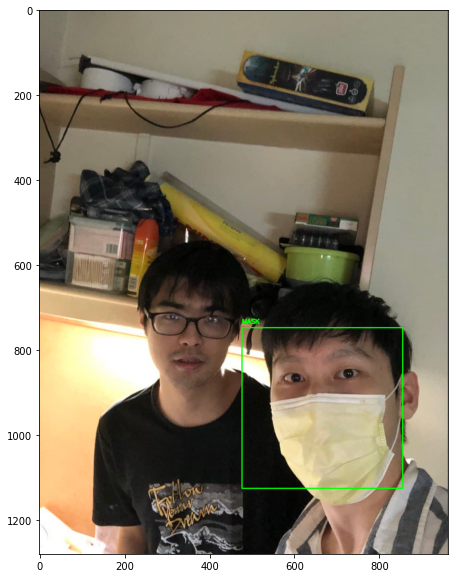

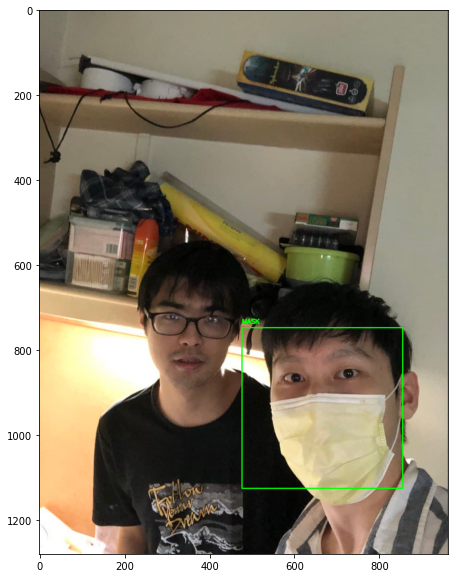

In [9]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier(
    '../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')
model = load_model('masknet-conv2d-relu.h5')
mask_label = {0: 'MASK', 1: 'NO MASK'}
color_label = {0: (0, 255, 0), 1: (255, 0, 0)}
def detect(image_id):
    # Read in an image
    # img = cv2.imread(f'../input/face-mask-detection/images/maksssksksss{image_id}.png')
    img = cv2.imread('/home/hr/Desktop/photo_2021-04-10_23-58-24.png')
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    # Detect faces
    faces = face_model.detectMultiScale(img)
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image
    for i in range(len(faces)):
        (x, y, w, h) = faces[i]
        crop = new_img[y:y + h, x:x + w]
        crop = cv2.resize(crop, (128, 128))
        crop = np.reshape(crop, [1, 128, 128, 3]) / 255.0
        mask_result = model.predict(crop)
        color = color_label[mask_result.argmax()]
        cv2.putText(
            new_img,
            mask_label[mask_result.argmax()],
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            color,
            2
        )
        cv2.rectangle(new_img, (x, y), (x+w, y+h), color, 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(new_img)

detect('331')
detect('455')